# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
import rpy2

In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==0.23.0 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load the FBM ECs

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8763
CD56 bright NK               449
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1357
GMP                         1281
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1000
MOP                         3838
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    353
arteriolar fibroblast         83
basophil                     139
chondrocyte                   80
early MK                    1624
early erythroid             7474
early osteoblast             280
endosteal fibroblast          5

In [7]:
celltypes = ['tip EC', 'proliferating EC', 'immature EC', 'sinusoidal EC']

In [8]:
adata = adata[adata.obs['cell.labels'].isin(celltypes)].copy()

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
immature EC          42
proliferating EC     26
sinusoidal EC       550
tip EC              362
dtype: int64

# Pre-process the dataset

In [10]:
# normalise count data 
sc.pp.normalize_total(adata)

In [11]:
# log the count data 
sc.pp.log1p(adata)

In [12]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [13]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [14]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Load the EC gene list

In [15]:
# load EC genes
genes = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/resources_for_pipelines/Fig6C_V3.csv", 
                    index_col=0, header=0)
genes["genes"] = genes.index
genes = genes["genes"].tolist()

In [16]:
genes

['NR2F2',
 'TFPI',
 'IL6ST',
 'ANGPTL4',
 'GMP6A',
 'VCAM1',
 'SEPP1',
 'CTSL',
 'IGFBP4',
 'STAB2',
 'ABCC9',
 'ACTG1',
 'CALD1',
 'CD34',
 'COL4A1',
 'COL4A2',
 'CXCL12',
 'EBF1',
 'EMP1',
 'GNAS',
 'SERPINH1',
 'SLC9A3R2',
 'SOX17',
 'TCF15',
 'TSPAN13',
 'VIM',
 'CD9',
 'CAVIN1',
 'CRIP2',
 'SPARCL1',
 'C1QTNF9',
 'MGLL',
 'KITLG',
 'CAV1',
 'S100A6',
 'S100A10',
 'IFITM2']

In [17]:
excluded_genes_list = ['GMP6A', 'CAVIN1']
new_genes = [gene for gene in genes if gene not in excluded_genes_list]
new_genes

['NR2F2',
 'TFPI',
 'IL6ST',
 'ANGPTL4',
 'VCAM1',
 'SEPP1',
 'CTSL',
 'IGFBP4',
 'STAB2',
 'ABCC9',
 'ACTG1',
 'CALD1',
 'CD34',
 'COL4A1',
 'COL4A2',
 'CXCL12',
 'EBF1',
 'EMP1',
 'GNAS',
 'SERPINH1',
 'SLC9A3R2',
 'SOX17',
 'TCF15',
 'TSPAN13',
 'VIM',
 'CD9',
 'CRIP2',
 'SPARCL1',
 'C1QTNF9',
 'MGLL',
 'KITLG',
 'CAV1',
 'S100A6',
 'S100A10',
 'IFITM2']

# Run heatmap plot for EC genes

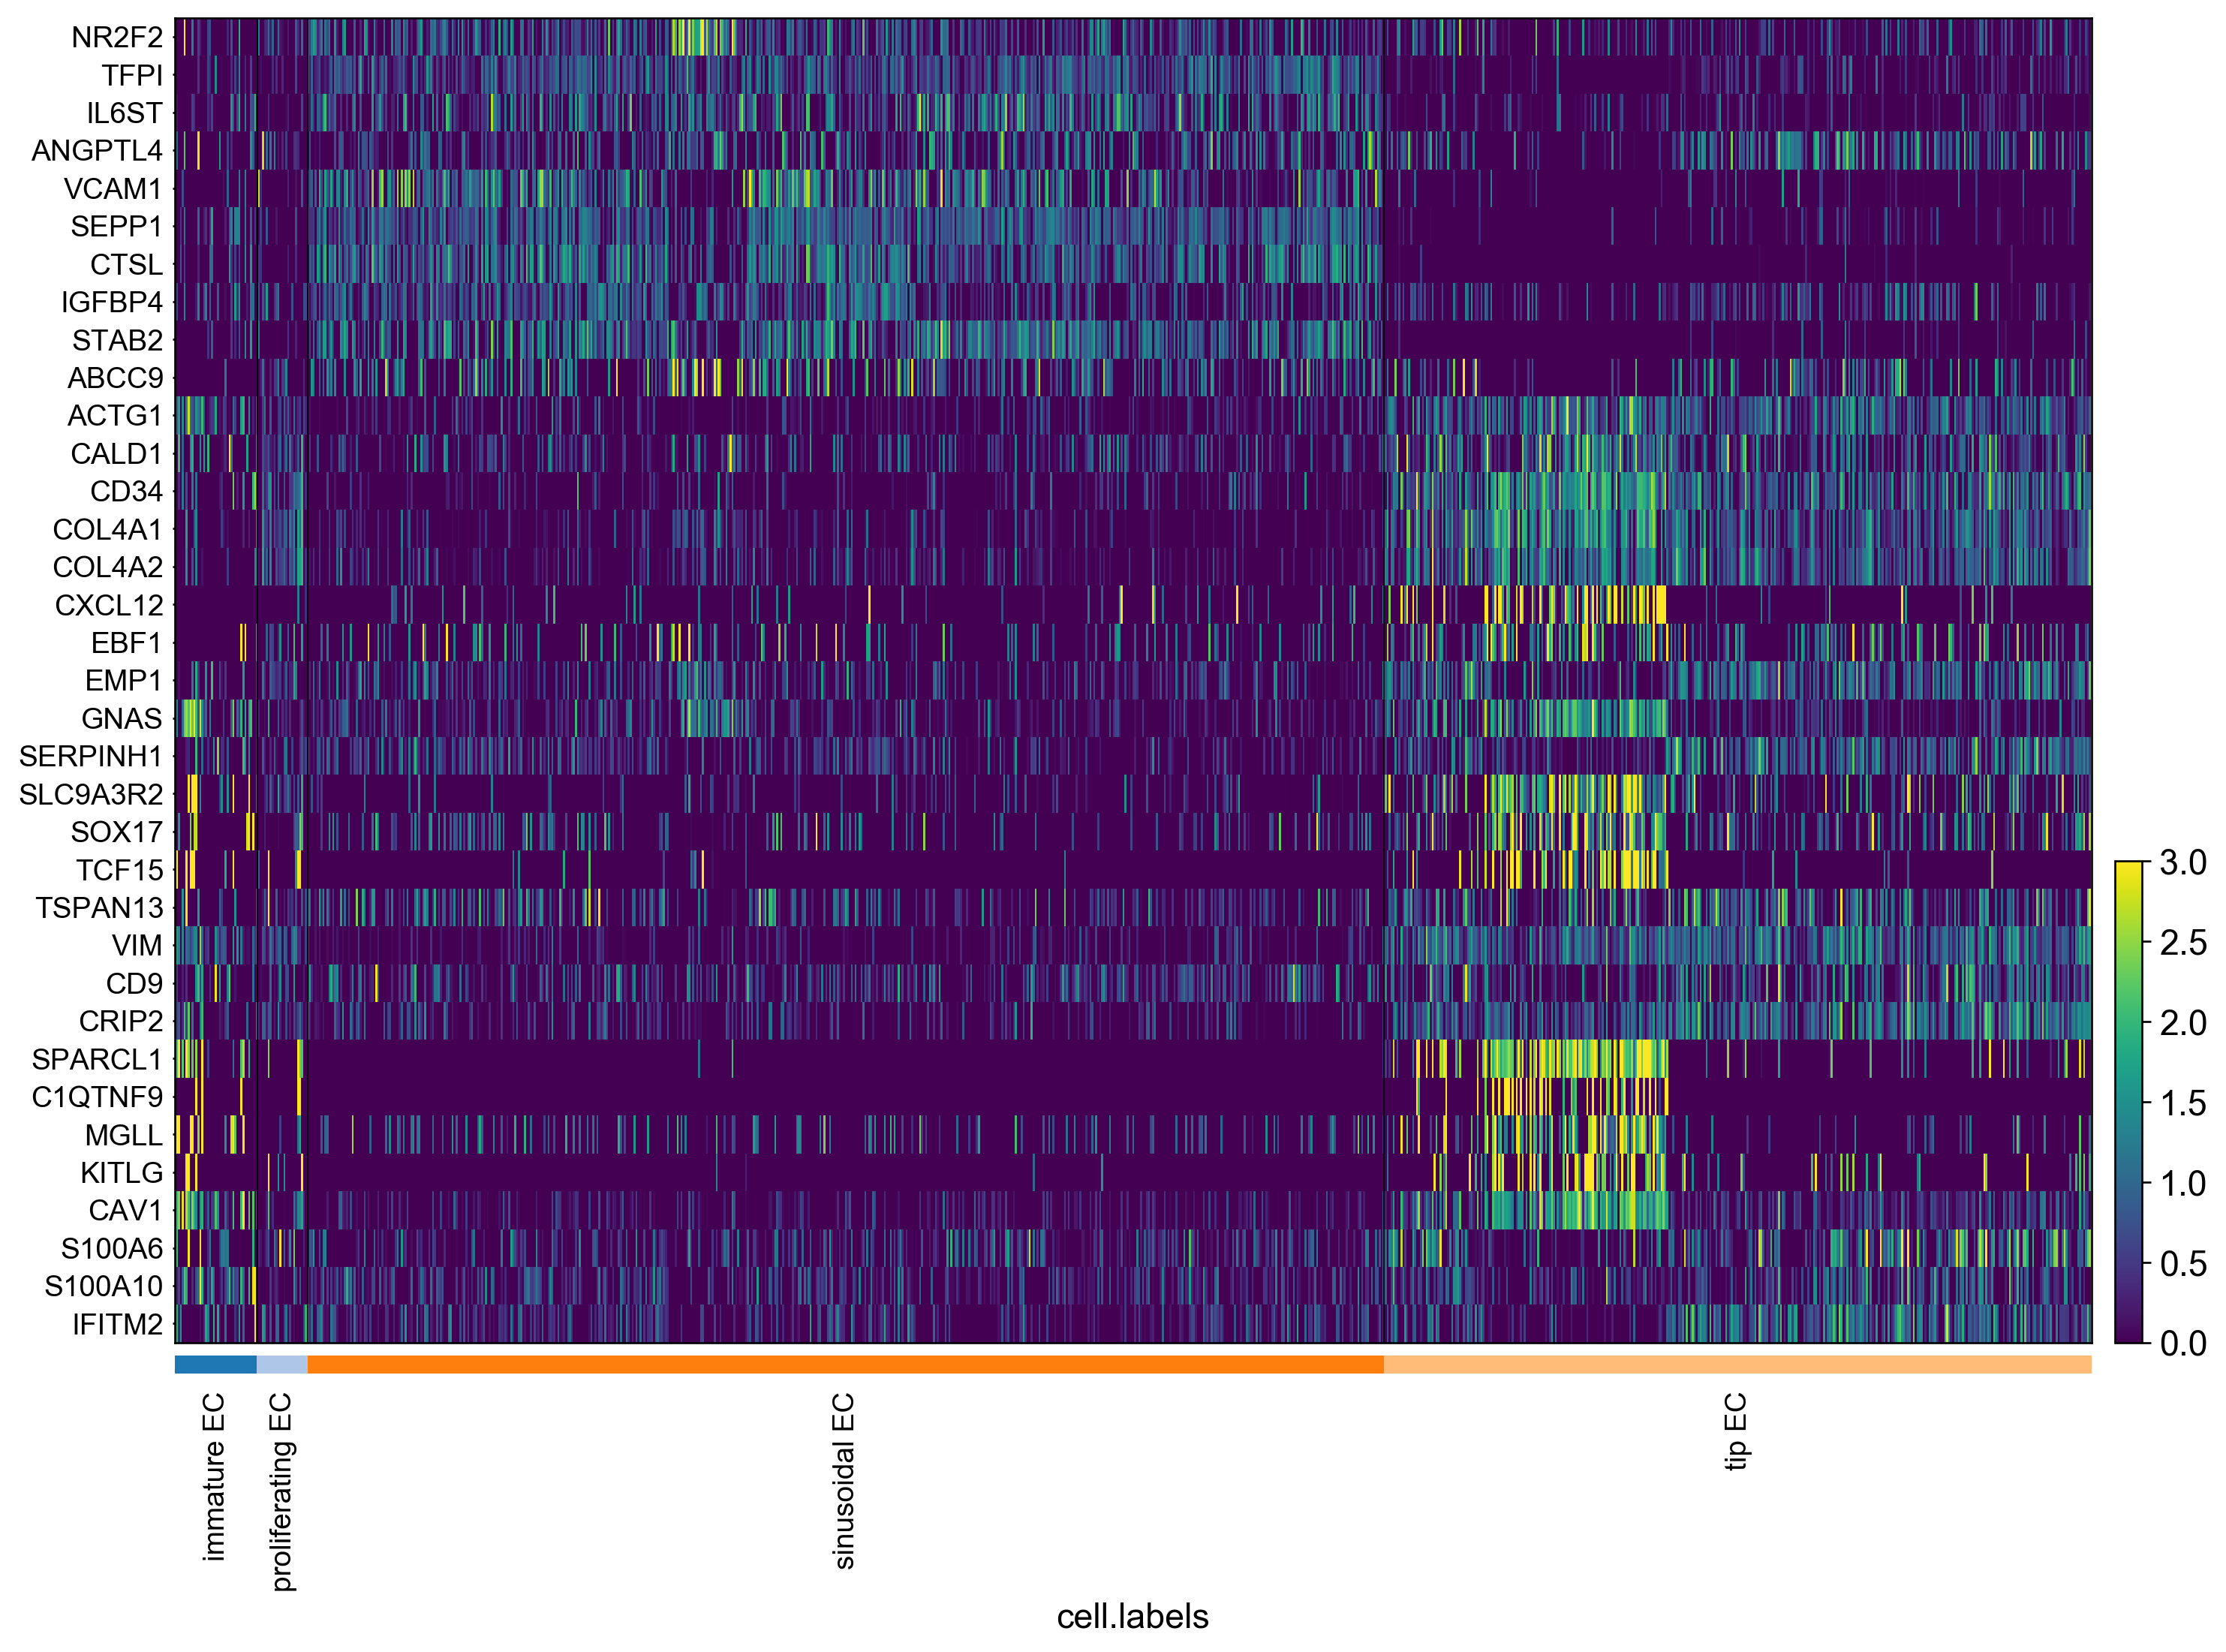

In [18]:
gs = sc.pl.heatmap(adata, var_names=new_genes,
                      save="fig6c_ec_genes_heatmap_20210427.pdf", 
                      groupby="cell.labels",
                      show_gene_labels=True, 
                      swap_axes=True, use_raw=False, figsize=[14,10], vmax=3)

In [19]:
adata.obs["index"] = adata.obs.index
adata.obs["index"] = pd.Categorical(adata.obs["index"])

cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
immature EC          42
proliferating EC     26
sinusoidal EC       550
tip EC              362
dtype: int64

In [20]:
subset = adata[adata.obs["cell.labels"].isin(["immature EC"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=new_genes, save="fig6c_heatmap_EC_genes_immatureEC_20210427.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[0.42,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [21]:
subset = adata[adata.obs["cell.labels"].isin(["proliferating EC"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=new_genes, save="fig6c_heatmap_EC_genes_prolifEC_20210427.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[0.26,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [22]:
subset = adata[adata.obs["cell.labels"].isin(["sinusoidal EC"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=new_genes, save="fig6c_heatmap_EC_genes_sinuEC_20210427.pdf.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[5.5,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [23]:
subset = adata[adata.obs["cell.labels"].isin(["tip EC"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=new_genes, save="fig6c_heatmap_EC_genes_tipEC_20210427.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[3.62,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

# Save the data

In [24]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
adata.raw.X

<980x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 2634831 stored elements in Compressed Sparse Row format>

In [26]:
del adata.obs["index"]

In [27]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk3/data/fig6c_heatmap_ec_genes_20210427.h5ad")